# Compute and save a table containg disk properties

The table saves disk properties (tau_P, tau_R, Sigma, cs, T_mid) on a grid of a_max, q, T_eff, and x. Here x is a proxy of Sigma/cs (see below).

At each set of (a_max, q, T_eff), only a finite range of (Sigma/cs) is possible. The min/max possible (Sigma/cs) are also stored in the table, and we linearly map the whole range of possible log(Sigma/cs) to x in [0,1]. This allows us to save the whole range of possible disk properties at given (a_max, q, T_eff).

In [1]:
from util import *
import matplotlib.pyplot as plt
from interp_table import InterpTable
import pickle

In [2]:
def T_from_tau(tau, T_eff, tau_r_mid, tau_p_mid):
    # get temperature at given tau (tau=tau_r)
    # Hubeny 1990 Eq 3.11
    T = T_eff * ( 3/4*(tau*(1-tau/(2*tau_r_mid)) + 1/np.sqrt(3) + 1/(3*tau_p_mid)) )**(1/4)
    return T
def tau_from_T(T, T_eff, tau_r_mid, tau_p_mid):
    # returns: (1) tau_R for this T, (2) whether this T is reachable in the given vertical temperature profile
    # Hubeny 1990 Eq 3.11
    T_ends = T_from_tau(np.array([0,tau_r_mid]), T_eff, tau_r_mid, tau_p_mid)
    # check whether temperature is reachable
    if T>=T_ends[1]:
        return tau_r_mid, False
    if T<=T_ends[0]:
        return 0, False
    a = -1/(2*tau_r_mid)
    b = 1
    c = 1/np.sqrt(3) + 1/3/(tau_p_mid) - T**4/(3/4*T_eff**4)
    tau = (-b+np.sqrt(b**2-4*a*c)) / (2*a)
    return tau, True
def vertical_profile_from_tau_mid(T_eff, tau_r_mid, tau_p_mid, f_kappa_r, f_kappa_p, T_crit):
    # generate vertical profile from given T_eff, tau_r_mid, and tau_p_mid
    # f_kappa_r, f_kappa_p are functions that takes T and returns opacity
    
    # generate tau grid
    N_tau = 100
    tauf = np.linspace(0,tau_r_mid,N_tau)
    tauf = tauf.tolist()
    # add critical temperatures
    for T_crit_one in T_crit:
        tau_crit, in_range = tau_from_T(T_crit_one, T_eff, tau_r_mid, tau_p_mid)
        if in_range:
            tauf.append(tau_crit)
    tauf = np.sort(np.array(tauf))
    tau = (tauf[1:]+tauf[:-1])/2
    dtau = tauf[1:]-tauf[:-1]
    T = T_from_tau(tau, T_eff, tau_r_mid, tau_p_mid)
    T_mid = T_from_tau(tau_r_mid, T_eff, tau_r_mid, tau_p_mid)
    kappa_r = f_kappa_r(T)
    kappa_p = f_kappa_p(T)
    cs = get_cs(T)
    Sigma = 2*np.sum(dtau/kappa_r)
    mean_cs = np.sum(cs*dtau/kappa_r)/np.sum(dtau/kappa_r)
    tau_p_mid_actual = np.sum(dtau*kappa_p/kappa_r)
    tau_p_over_tau_r_actual = tau_p_mid_actual/tau_r_mid
    return Sigma, mean_cs, T_mid, tau_p_over_tau_r_actual
def solve_vertical_profile_from_tau_p(T_eff, tau_p_mid, f_kappa_r, f_kappa_p, T_crit):
    # solve disk profile at given tau_p
    # this iteratively updates tau_r and calls vertical_profile_from_tau_mid()
    # as long as kappa>0, any tau_p should still correspond to some profile
    tau_r_mid = tau_p_mid
    err = 1
    err_tol = 1e-8
    n_itr = 0
    n_itr_max = 200
    while n_itr<n_itr_max and err>err_tol:
        n_itr += 1
        res = vertical_profile_from_tau_mid(T_eff, tau_r_mid, tau_p_mid, f_kappa_r, f_kappa_p, T_crit)
        tau_r_mid_actual = tau_p_mid / res[-1]
        err = np.abs(tau_r_mid_actual/tau_r_mid - 1)
        tau_r_mid = tau_r_mid_actual
    Sigma, mean_cs, T_mid, tau_p_over_tau_r_actual = vertical_profile_from_tau_mid(T_eff, tau_r_mid, tau_p_mid, f_kappa_r, f_kappa_p, T_crit)
    return tau_r_mid, Sigma, mean_cs, T_mid

In [3]:
def generate_vertical_profile_at_T_eff(T_eff, f_kappa_r, f_kappa_p, T_crit, N_Sigma_cs=20):
    tau_p_list = []
    tau_r_list = []
    Sigma_list = []
    cs_list = []
    T_mid_list = []

    # start at tau_p = 1, go in two directions
    
    dtau = 0.2
    N_tau_max = 100 # max n_steps in each direction
    speed_up_factor = 1/50
    T_subl = T_crit[-1]

    tau_p = 1
    subl = False
    n_itr = 0
    min_Sigma_cs = np.inf
    while n_itr<N_tau_max and (not subl or tau_p>.1):
        n_itr += 1
        res = solve_vertical_profile_from_tau_p(T_eff, tau_p, f_kappa_r, f_kappa_p, T_crit)
        if (res[1]/res[2])<min_Sigma_cs:
            # only include this point if it probes a lower Sigma/cs.
            # this avoids having a single Sigma/cs mapping to multiple states.
            # generally this selection criterion corresponds to prefering the state with lower T_mid.
            min_Sigma_cs = res[1]/res[2]
            tau_p_list.append(tau_p)
            tau_r_list.append(res[0])
            Sigma_list.append(res[1])
            cs_list.append(res[2])
            T_mid_list.append(res[3])
        subl = res[3]>T_subl
        tau_p = tau_p/(1+dtau)**(1+n_itr*speed_up_factor)

    tau_p_list = tau_p_list[::-1]
    tau_r_list = tau_r_list[::-1]
    Sigma_list = Sigma_list[::-1]
    cs_list = cs_list[::-1]
    T_mid_list = T_mid_list[::-1]

    tau_p = 1
    subl = False
    n_itr = 0
    while n_itr<N_tau_max and (not subl or tau_p<10):
        tau_p = tau_p*(1+dtau)**(1+n_itr*speed_up_factor)
        n_itr += 1
        res = solve_vertical_profile_from_tau_p(T_eff, tau_p, f_kappa_r, f_kappa_p, T_crit)
        tau_p_list.append(tau_p)
        tau_r_list.append(res[0])
        Sigma_list.append(res[1])
        cs_list.append(res[2])
        T_mid_list.append(res[3])
        subl = res[3]>T_subl

    tau_p_list = np.array(tau_p_list)
    tau_r_list = np.array(tau_r_list)
    Sigma_list = np.array(Sigma_list)
    cs_list = np.array(cs_list)
    T_mid_list = np.array(T_mid_list)
    
    # get rid of points with T>T_subl
    Sigma_cs_min = (Sigma_list/cs_list)[np.argmin(T_mid_list)]
    tau_p_list = tau_p_list[T_mid_list<T_subl]
    tau_r_list = tau_r_list[T_mid_list<T_subl]
    Sigma_list = Sigma_list[T_mid_list<T_subl]
    cs_list = cs_list[T_mid_list<T_subl]
    T_mid_list = T_mid_list[T_mid_list<T_subl]
    
    x = np.linspace(0,1,N_Sigma_cs)
    
    if len(T_mid_list) < 2:
        Sigma_cs_l = Sigma_cs_min
        Sigma_cs_r = Sigma_cs_min
        tau_p = np.ones_like(x) * small_number
        tau_r = np.ones_like(x) * small_number
        Sigma = np.ones_like(x) * small_number
        cs = np.ones_like(x) * small_number
        T_mid = np.ones_like(x) * small_number
    else:
        # find critiical Sigma/cs (when T_mid=T_subl)
        f_Sigma_cs_l = interp1d_log(T_mid_list[:2], (Sigma_list/cs_list)[:2])
        f_Sigma_cs_r = interp1d_log(T_mid_list[-2:], (Sigma_list/cs_list)[-2:])
        Sigma_cs_l = f_Sigma_cs_l(T_subl)
        Sigma_cs_r = f_Sigma_cs_r(T_subl)
        # remap data between critical values
        Sigma_cs = Sigma_cs_l * (Sigma_cs_r/Sigma_cs_l)**x
        f_tau_p = interp1d_log(Sigma_list/cs_list, tau_p_list)
        f_tau_r = interp1d_log(Sigma_list/cs_list, tau_r_list)
        f_Sigma = interp1d_log(Sigma_list/cs_list, Sigma_list)
        f_cs    = interp1d_log(Sigma_list/cs_list, cs_list)
        f_T_mid = interp1d_log(Sigma_list/cs_list, T_mid_list)
        tau_p = f_tau_p(Sigma_cs)
        tau_r = f_tau_r(Sigma_cs)
        Sigma = f_Sigma(Sigma_cs)
        cs    = f_cs(Sigma_cs)
        T_mid = f_T_mid(Sigma_cs)

    return [Sigma_cs_l, Sigma_cs_r], [tau_p, tau_r, Sigma, cs, T_mid]

In [4]:
disk_opacity = pickle.load(open('./data/opacity_tables/disk_opacity.pkl','rb'))

In [5]:
disk_opacity

InterpTable object with 3 dims
Axes:
  [0] log_T, length=38
  [1] log_amax, length=15
  [2] q, length=5
Data fields, shape=[38, 15, 5]:
  log_kappa_abs_p
  log_kappa_abs_r
  log_kappa_sca_eff_p
  log_kappa_sca_eff_r

In [6]:
np.exp(disk_opacity.grid['log_T'])

array([   5.        ,    6.08678524,    7.40979091,    9.02036118,
         10.98100025,   13.36779805,   16.27338316,   19.81051768,
         24.11647331,   29.35835874,   35.73960492,   43.50785993,
         52.9645999 ,   64.47682896,   78.49132213,   95.55196417,
        116.32085698,  141.60401502,  149.99999999,  150.00000001,
        172.38264564,  209.85122853,  255.46387198,  310.99074494,
        378.58677506,  424.99999999,  425.00000001,  460.87527871,
        561.04976856,  679.99999999,  680.00000001,  682.99788976,
        831.45229452, 1012.1743104 , 1199.99999999, 1200.00000001,
       1232.17753007, 1500.        ])

# Example: compute disk rpofile at given T_eff as a function of tau_p

In [7]:
disk_opacity_a = disk_opacity.replace_grid('log_amax', np.log(0.01))
disk_opacity_aq = disk_opacity_a.replace_grid('q', 3.5)

In [8]:
f_kappa_r = lambda T: disk_opacity_aq.interp('log_kappa_abs_r', log_T=T, loglog=True)
f_kappa_p = lambda T: disk_opacity_aq.interp('log_kappa_abs_p', log_T=T, loglog=True)

In [9]:
T_eff = 100
tau_p_mid = np.logspace(-4, 2, 200)
Sigma = []
cs = []
T_mid = []
for t in tau_p_mid:
    res = solve_vertical_profile_from_tau_p(T_eff, t, f_kappa_r, f_kappa_p, [150, 425, 680, 1200])
    Sigma.append(res[1])
    cs.append(res[2])
    T_mid.append(res[3])

101.52354528052032


Text(0.5, 1.0, 'at T_eff = 100K')

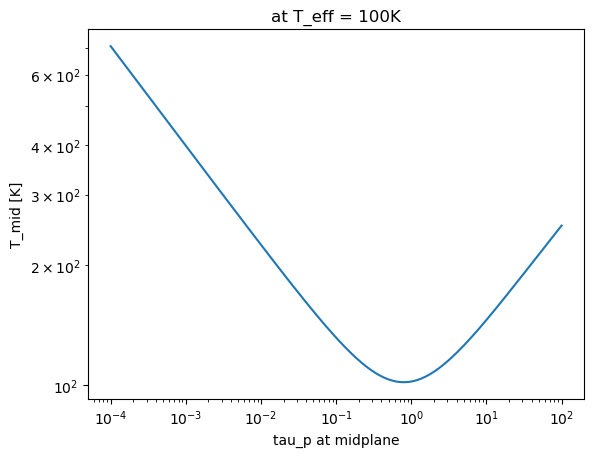

In [10]:
#plt.plot(tau_p_mid, Sigma)
#plt.plot(tau_p_mid, cs)
plt.plot(tau_p_mid, T_mid)
print(np.amin(T_mid))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('tau_p at midplane')
plt.ylabel('T_mid [K]')
plt.title('at T_eff = 100K')

Text(0.5, 1.0, 'at T_eff = 100K')

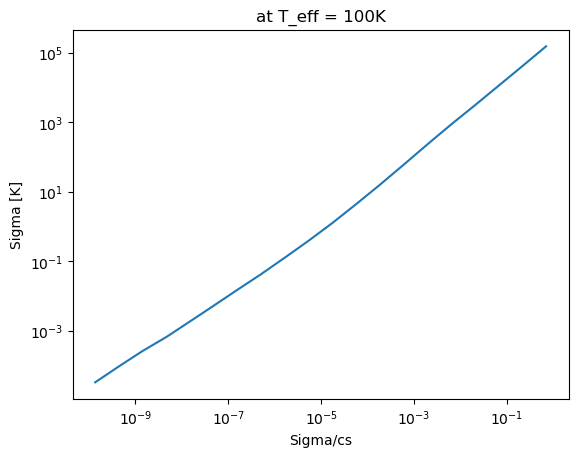

In [11]:
T_eff = 100
bounds, properties = generate_vertical_profile_at_T_eff(T_eff, f_kappa_r, f_kappa_p, [150, 425, 680, 1200], N_Sigma_cs=20)
x = np.linspace(0,1,len(properties[0]))
Sigma_cs = bounds[0] * (bounds[1]/bounds[0])**x
plt.plot(Sigma_cs,properties[2])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sigma/cs')
plt.ylabel('Sigma [K]')
plt.title('at T_eff = 100K')

In [12]:
def generate_disk_property_table(disk_opacity, T_crit=[150, 425, 680, 1200], T_eff_min=0.5, T_eff_max=1500, N_T_eff=30, N_Sigma_cs=20):
    disk_property_table = InterpTable()
    disk_property_table.add_grid('log_amax', disk_opacity.grid['log_amax'])
    disk_property_table.add_grid('q', disk_opacity.grid['q'])
    T_eff = np.logspace(np.log10(T_eff_min), np.log10(T_eff_max), N_T_eff)
    disk_property_table.add_grid('log_T_eff', np.log(T_eff))
    disk_property_table.add_grid('x', np.linspace(0,1,N_Sigma_cs))
    disk_property_table.add_data('log_Sigma_cs_l')
    disk_property_table.add_data('log_Sigma_cs_r')
    disk_property_table.add_data('log_tau_p')
    disk_property_table.add_data('log_tau_r')
    disk_property_table.add_data('log_Sigma')
    disk_property_table.add_data('log_cs')
    disk_property_table.add_data('log_T_mid')
    for ia,log_amax in enumerate(disk_property_table.grid['log_amax']):
        for iq,q in enumerate(disk_property_table.grid['q']):
            print('computing a_max = {}, q = {}'.format(np.exp(log_amax), q))
            disk_opacity_a = disk_opacity.replace_grid('log_amax', log_amax)
            disk_opacity_aq = disk_opacity_a.replace_grid('q', q)
            f_kappa_r = lambda T: disk_opacity_aq.interp('log_kappa_abs_r', log_T=T, loglog=True)
            f_kappa_p = lambda T: disk_opacity_aq.interp('log_kappa_abs_p', log_T=T, loglog=True)
            for iT,T_eff_1 in enumerate(T_eff):
                bounds, properties = generate_vertical_profile_at_T_eff(T_eff_1, f_kappa_r, f_kappa_p, T_crit, N_Sigma_cs=N_Sigma_cs)
                disk_property_table.data['log_Sigma_cs_l'][ia, iq, iT, :] = np.log(bounds[0])
                disk_property_table.data['log_Sigma_cs_r'][ia, iq, iT, :] = np.log(bounds[1])
                disk_property_table.data['log_tau_p'][ia, iq, iT, :] = np.log(properties[0])
                disk_property_table.data['log_tau_r'][ia, iq, iT, :] = np.log(properties[1])
                disk_property_table.data['log_Sigma'][ia, iq, iT, :] = np.log(properties[2])
                disk_property_table.data['log_cs'][ia, iq, iT, :] = np.log(properties[3])
                disk_property_table.data['log_T_mid'][ia, iq, iT, :] = np.log(properties[4])
    disk_property_table.create_interp_fn_all_data()
    return disk_property_table

### a_max and q grids are taken from the disk opacity table. T_eff and x grids can be specified below.

In [13]:
disk_property_table = generate_disk_property_table(disk_opacity,
                        T_eff_min=0.5, T_eff_max=1500, N_T_eff=30, N_Sigma_cs=20)

computing a_max = 1.0000000000000004e-06, q = 2.5
computing a_max = 1.0000000000000004e-06, q = 2.75
computing a_max = 1.0000000000000004e-06, q = 3.0
computing a_max = 1.0000000000000004e-06, q = 3.25
computing a_max = 1.0000000000000004e-06, q = 3.5
computing a_max = 3.162277660168377e-06, q = 2.5
computing a_max = 3.162277660168377e-06, q = 2.75
computing a_max = 3.162277660168377e-06, q = 3.0
computing a_max = 3.162277660168377e-06, q = 3.25
computing a_max = 3.162277660168377e-06, q = 3.5
computing a_max = 9.999999999999997e-06, q = 2.5
computing a_max = 9.999999999999997e-06, q = 2.75
computing a_max = 9.999999999999997e-06, q = 3.0
computing a_max = 9.999999999999997e-06, q = 3.25
computing a_max = 9.999999999999997e-06, q = 3.5
computing a_max = 3.16227766016838e-05, q = 2.5
computing a_max = 3.16227766016838e-05, q = 2.75
computing a_max = 3.16227766016838e-05, q = 3.0
computing a_max = 3.16227766016838e-05, q = 3.25
computing a_max = 3.16227766016838e-05, q = 3.5
computing a_

In [14]:
disk_property_table

InterpTable object with 4 dims
Axes:
  [0] log_amax, length=15
  [1] q, length=5
  [2] log_T_eff, length=30
  [3] x, length=20
Data fields, shape=[15, 5, 30, 20]:
  log_Sigma_cs_l
  log_Sigma_cs_r
  log_tau_p
  log_tau_r
  log_Sigma
  log_cs
  log_T_mid

In [15]:
save_disk_property = False
if save_disk_property:
    pickle.dump(disk_property_table, open('./data/opacity_tables/disk_property.pkl','wb'))